In [2]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import sys

# Set the root directory to Sorrento Home path
root_path = Path.cwd().parents[0]
sys.path.append(str(root_path))

from scripts.env import *

### Plot some of the good predictions

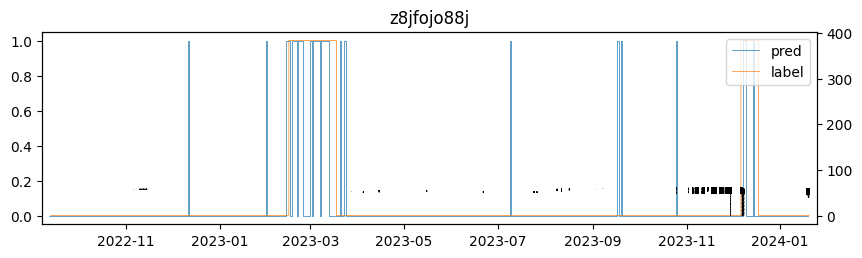

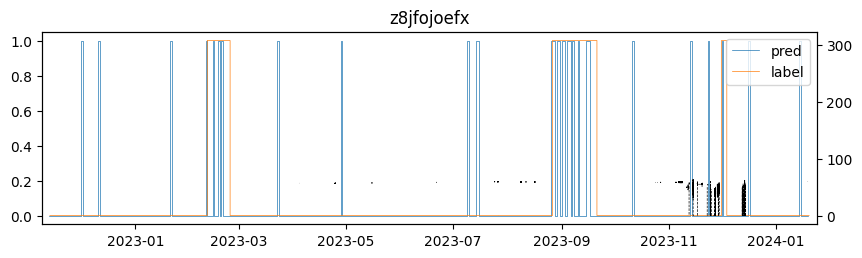

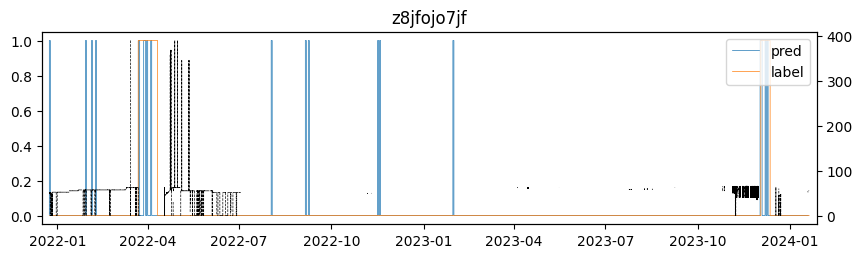

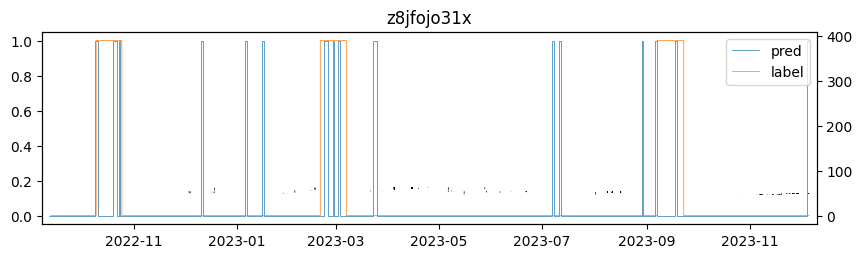

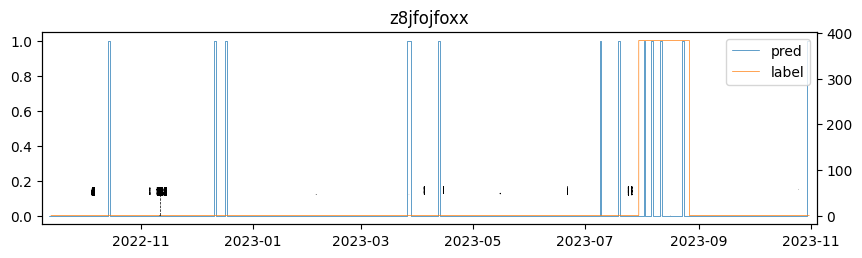

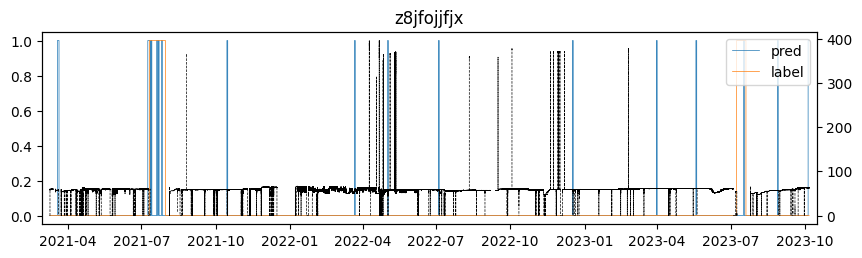

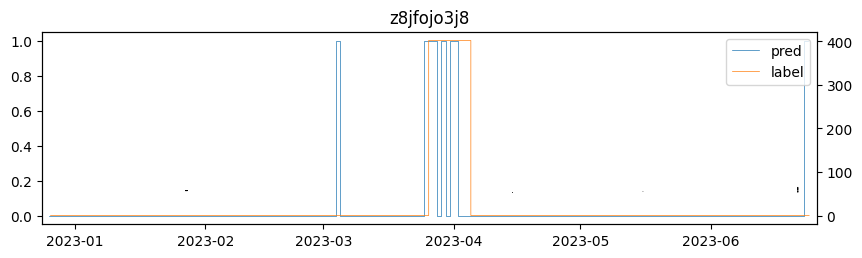

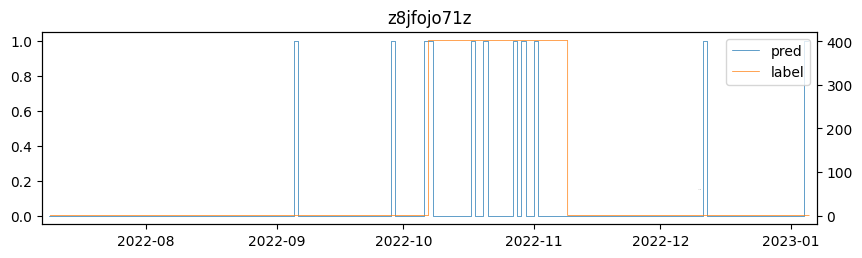

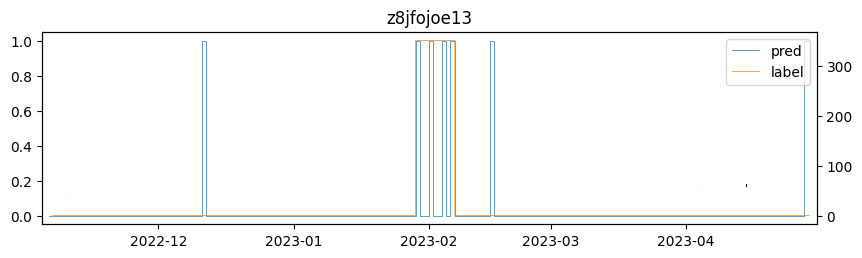

In [101]:
pred_folders = sorted(glob(f"../{PRED_FOL}_{SLIDE_N}/*.csv"))
file = np.random.choice(pred_folders)
good_wells = ["z8jfojo88j", "z8jfojoefx", "z8jfojo7jf", "z8jfojo31x", "z8jfojfoxx", "z8jfojjfjx", "z8jfojo3j8", "z8jfojo71z", "z8jfojoe13"]


for _a in good_wells:
    file = f"../{PRED_FOL}_{SLIDE_N}/pred_{_a}.csv"
    API = file.split("/")[-1].replace(".csv","").split("_")[1]
    label_folder = sorted(glob(f"../{ESP_OUTPUT_FOLDER}_{SLIDE_N}/{API}/*.parquet"))
    label_df = pd.concat([pd.read_parquet(file) for file in label_folder])
    label_df.sort_index()


    df = pd.read_csv(file)
    df["Date"] = pd.to_datetime(df["Date"])
    fig,ax = plt.subplots(figsize=(10,2.5))
    ax.step(df.Date, df.Fail, lw=0.5, label="pred")
    ax.step(label_df.index, label_df.Label, lw=0.5, label="label")
    ax.legend(loc="upper right")
    ax.set_title(df.API[0])
    ax.margins(x=0.01)
    bx = ax.twinx()
    bx.plot(label_df.index, label_df.motor_frequency, c="k", lw=0.5, ls="--")
    # bx.plot(label_df.index, label_df.output_amps_phase_b, c="k", lw=0.5, ls="--")
    # bx.set_ylim(0,10)
    plt.show()